In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import warnings
import math
from numpy import linalg as LA
from numpy import random, nanmax, argmax, unravel_index
from scipy.spatial.distance import pdist, squareform

warnings.filterwarnings('ignore')
%matplotlib inline


In [56]:
about_data_df=pd.read_csv('./data/encirclement/about_data.csv')

In [58]:
about_data_df.head(3)

,case,filename,lpv,si
0,Case_1,case1_lpv,1,247
1,Case_1,case1_rpv,0,247
2,Case_2,case2_lpv,1,59


In [59]:
data_path_prefix = './data/encirclement/'

In [10]:
#df_data = pd.read_csv('./data/encirclement/point_lesion/AS_RPV.csv')  

# for CF
#df_data = pd.read_csv('./data/encirclement/control/CF_RPV.csv')  
#df_data = pd.read_csv('./data/encirclement/control/CF_LPV_7NN.csv')  
df_data = pd.read_csv('./data/encirclement/control/CF_LPV_3NN.csv')  

# for DP
#df_data = pd.read_csv('./data/encirclement/point_lesion/DP_RPV_7NN.csv')  
#df_data = pd.read_csv('./data/encirclement/point_lesion/DP_LPV_7NN.csv')  

# for new cases 
df_data = pd.read_csv('./data/encirclement/point_lesion/case2_LPV.csv')  

# This line always stays 
df_data = df_data[df_data.VertexID.duplicated(keep=False)]

In [92]:

# t_nogap is the cut-off where a value above t_nogap means no gap 
def CircularPiePlotScarGap(df, t_nogap, no_plot=None):
    count = len(df.as_matrix())
    #scalars = df_data_with_theta.as_matrix(columns=df_data_with_theta.columns[7:8])
    scalars = df['MeshScalar'].as_matrix()
    num_prim_groups = 4 #  Do not change as pie plot is hard-coded to accept four primary groups
    num_sub_groups = 4  #  Do not change as pie plot is hard-coded to accept four primary groups
    total_groups = num_prim_groups*num_sub_groups
    sub_group_size = count/total_groups

    # Divide the data into 12 groups, 4 regions x 3 sub-regions, regions = post sup, post inf, etc. 
    sub_group_array = np.zeros(shape=(total_groups, 1))

    n=0
    sb = np.array_split(scalars, total_groups)
    for i in sb: 
        sub_group_array[n] = np.mean(i)
        n += 1
        
    
    # binary classify sub_groups into gaps and no-gaps 
    bin_subgrouparray = sub_group_array > t_nogap
    bin_subgrouparray = bin_subgrouparray * 1    # converts the false true array to 0 1 
    
    # Now prepare data for circular plot 
    
    # First decide color sub-groups based on binary classification of sub_groups (i.e. t_nogaps)
    a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
    color_subgroups = list() 
    for x in bin_subgrouparray: 
        if x == 1:
            color_subgroups.append(b(0.5))
        else:
            color_subgroups.append(c(0.5))
    
    # Decide color of the primary groups (n=4) based on number of sub_groups classified as gaps/no-gaps 
    color_primgroups = list()
    prim_group_array = np.zeros(shape=(num_prim_groups, 1))
        
    # classify primary groups 
    prim_group_array = np.split(bin_subgrouparray, num_prim_groups)
    n=0
    for i in prim_group_array: 
        prim_group_array[n] = np.sum(i)
        n += 1
        
    for x in prim_group_array: 
        if x==1:
            color_primgroups.append('green')
        elif x==2: 
            color_primgroups.append('yellow')
        elif x==3:
            color_primgroups.append('gold')
        elif x==4:
            color_primgroups.append('red')
        else:
            color_primgroups.append('green')   # x == 0
        
        
        
    # Make data: I have 3 groups and 7 subgroups
    group_names=['Post-Sup (A)', 'Ant-Sup (B)', 'Ant-Inf (C)', 'Post-Inf (D)']
    group_size=[1,1,1,1]
    subgroup_names=['A1', 'A2', 'A3', 'A4','B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3', 'D4']
    subgroup_size=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    
    if no_plot is None: 
        # First Ring (outside)
        fig, ax = plt.subplots()
        ax.axis('equal')
        mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=color_primgroups )
        plt.setp( mypie, width=0.3, edgecolor='white')

        # Second Ring (Inside)
        mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=color_subgroups)
        plt.setp( mypie2, width=0.4, edgecolor='white')
        plt.margins(0,0)

        # show it
        plt.show()
    else: 
        return bin_subgrouparray
        

In [93]:

# t_nogap is the cut-off where a value above t_nogap means no gap 
def CircularPiePlotScarWidth(df, t_scar, no_plot=None):
    count = len(df.as_matrix())
    #scalars = df_data_with_theta.as_matrix(columns=df_data_with_theta.columns[7:8])
    scalars = df['MeshScalar'].as_matrix()
    num_prim_groups = 4 #  Do not change as pie plot is hard-coded to accept four primary groups
    num_sub_groups = 4  #  Do not change as pie plot is hard-coded to accept four primary groups
    total_groups = num_prim_groups*num_sub_groups
    sub_group_size = count/total_groups
     
    # assigning each point into one of 16 sub-groups in the polar plot (sub_group_size = num_vertices/16)
    df['scar_bin'] = df['MeshScalar'] > t_scar 
    df['scar_bin'] = df['scar_bin'] * 1 
    df['polar_group'] = df['MainVertexSeq']
    for i, row in df.iterrows():
        #row['polar_group'] = math.ceil(index / sub_group_size )
        df.at[i, 'polar_group'] = math.ceil(i / sub_group_size )
    
    # See https://stackoverflow.com/questions/31667070/max-distance-between-2-points-in-a-data-set-and-identifying-the-points
    total_width_in_each_subgrp = []
    scar_width_in_each_subgrp = []
    for i in range(0, total_groups):
        df_temp = df[df['polar_group']==i]
        xyz = df_temp.as_matrix(columns=['X', 'Y', 'Z'])
        D = pdist(xyz) # pair-wise distances 
        D = squareform(D)
        N, [I_row, I_col] = nanmax(D), unravel_index( argmax(D), D.shape )
        total_width_in_each_subgrp.append(round(N,2))
        
        # now select rows that was classified as scar
        df_temp2 = df_temp[df_temp['scar_bin'] == 1]
        xyz = df_temp2.as_matrix(columns=['X', 'Y', 'Z'])
        D = pdist(xyz) # pair-wise distances 
        D = squareform(D)
        N, [I_row, I_col] = nanmax(D), unravel_index( argmax(D), D.shape )
        scar_width_in_each_subgrp.append(round(N,2))
    
    # calculate scar width percentage 
    scar_width_percentage = []
    i=0
    while i < len(scar_width_in_each_subgrp):
        total = total_width_in_each_subgrp[i]
        this_scar = scar_width_in_each_subgrp[i]
        scar_width_percentage.append(this_scar/total)
        i+=1
    scar_width_percentage = np.asarray(scar_width_percentage)
    # Now prepare data for circular plot 
    
    # First decide color sub-groups based on binary classification of sub_groups (i.e. t_nogaps)
    a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
    color_subgroups = list() 
    for x in scar_width_percentage: 
        if x >= 0.75:
            color_subgroups.append('red')
        elif x >= 0.5 and x < 0.75:
            color_subgroups.append('gold')
        elif x >= 0.25 and x < 0.5: 
            color_subgroups.append('yellow')
        elif x >= 0 and x < 0.25: 
            color_subgroups.append('green')
       
            
    # Decide color of the primary groups (n=4) based on number of sub_groups classified as gaps/no-gaps 
    color_primgroups = list()
    prim_group_array = np.zeros(shape=(num_prim_groups, 1))
        
    # classify primary groups 
    prim_group_array = np.split(scar_width_percentage, num_prim_groups)
    n=0
    for i in prim_group_array: 
        prim_group_array[n] = np.mean(i)
        n += 1
        
    for x in prim_group_array: 
        if x >= 0.75:
            color_primgroups.append('red')
        elif x >= 0.5 and x < 0.75:
            color_primgroups.append('gold')
        elif x >= 0.25 and x < 0.5: 
            color_primgroups.append('yellow')
        elif x > 0 and x < 0.25: 
            color_primgroups.append('green')
        else:
            color_primgroups.append('green')   # x == 0
        
        
        
    # Make data: I have 3 groups and 7 subgroups
    group_names=['Post-Sup (A)', 'Ant-Sup (B)', 'Ant-Inf (C)', 'Post-Inf (D)']
    group_size=[1,1,1,1]
    subgroup_names=['A1', 'A2', 'A3', 'A4','B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3', 'D4']
    subgroup_size=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    
    # First Ring (outside)
    if no_plot is None:
        fig, ax = plt.subplots()
        ax.axis('equal')
        mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=color_primgroups )
        plt.setp( mypie, width=0.3, edgecolor='white')

        # Second Ring (Inside)
        mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=color_subgroups)
        plt.setp( mypie2, width=0.4, edgecolor='white')
        plt.margins(0,0)

        # show it
        plt.show()
    else: 
        return total_width_in_each_subgrp
    
    print ("Complete widths in each sub-segment", total_width_in_each_subgrp) 
    print ("Scar widths in each sub-segment", scar_width_in_each_subgrp) 


In [97]:
# writes the output of circular pie plot to file 
def WriteCSV(np_array, case_name, filename_csv, append_col=None):
    df = pd.DataFrame(np_array)
    df_T = df.T
    
    # an extra column to specify if lpv or rpv
    if append_col is not None:
        df_T['xcol'] = append_col
        cols = df_T.columns.tolist()
        df_T = df_T[[cols[-1]] + cols[:-1]]
        
    df_T['case'] = case_name
    cols = df_T.columns.tolist()
    df_T = df_T[[cols[-1]] + cols[:-1]] 
    
    with open(filename_csv, 'a') as f:
        df_T.to_csv(f, header=False)

In [98]:
def ProcessAllCases(about_data_df): 
    data_path_prefix = './data/encirclement/test_script/'
    csv_filename_gaps = './data/encirclement/scar_gaps.csv'
    csv_filename_width = './data/encirclement/scar_width.csv'
    for index, row in about_data_df.iterrows():
        path_to_data = data_path_prefix + row['filename'] + '.csv'
        df_data = pd.read_csv(path_to_data)  
        df_data_for_gaps = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)
        scar_gaps = CircularPiePlotScarGap(df_data_for_gaps, row['si'], 'no plot')
        scar_width = CircularPiePlotScarWidth(df_data, row['si'], 'no plot')
        WriteCSV(scar_gaps, row['case'], csv_filename_gaps, row['lpv'])
        WriteCSV(scar_width, row['case'], csv_filename_width, row['lpv'])
    

In [99]:
ProcessAllCases(about_data_df)

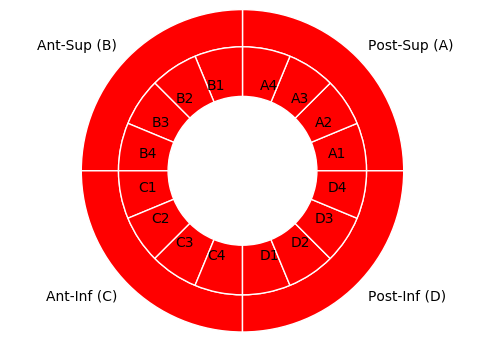

('Complete widths in each sub-segment', [11.17, 13.34, 17.72, 21.55, 23.16, 24.9, 24.32, 23.39, 19.86, 19.63, 20.49, 20.79, 20.39, 18.85, 16.36, 12.79])
('Scar widths in each sub-segment', [11.17, 13.34, 17.72, 21.55, 23.16, 24.9, 24.32, 23.39, 18.4, 19.63, 20.49, 20.79, 20.39, 18.85, 16.36, 12.79])


In [26]:
scar_widths = CircularPiePlotScarWidth(df_data,59)   # use 0.5 for DP and 4.5 for CF

In [19]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

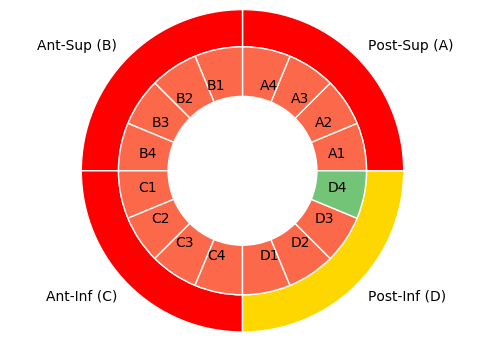

In [27]:
scar_gaps = CircularPiePlotScarGap(df_data_scalars,59)   # use 0.5 for DP and 4.5 for CF

In [28]:
print scar_grps

[94 94 93 ..., 57 68 68]


In [34]:
scar_grps.mean()

78.607065919862123

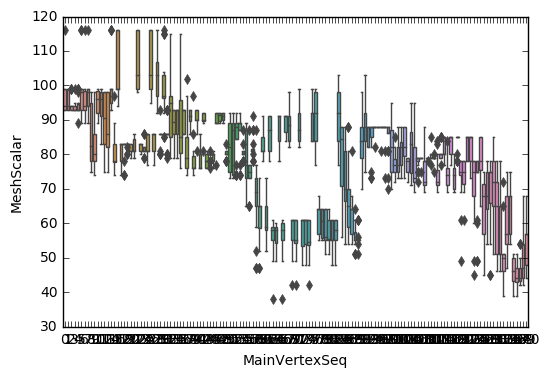

In [30]:
ax = sns.boxplot(x="MainVertexSeq", y="MeshScalar", data=df_data_scalars)

In [10]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

In [11]:
g1.head(2)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar
0,0,2977.0,-14.36800,33.0381,88.25490,1.0,43.0
1,1,2994.5,-13.75355,34.7513,87.76805,1.0,33.5


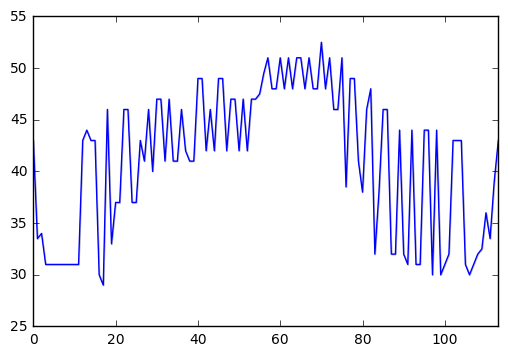

In [243]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [210]:
center_data = [df_data['X'].mean(), df_data['Y'].mean(), df_data['Z'].mean()]

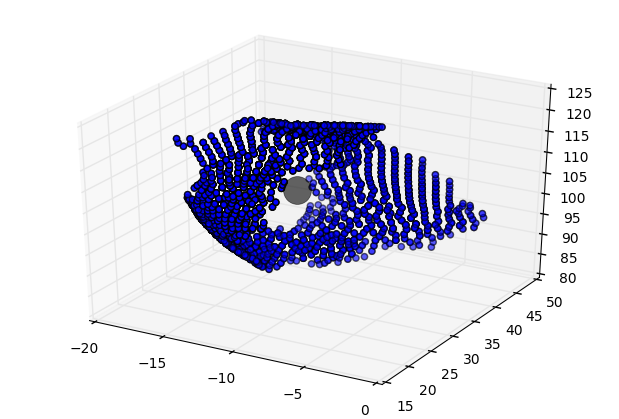

In [211]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_data['X'], df_data['Y'], df_data['Z'])
ax.plot([center_data[0]], [center_data[1]], [center_data[2]], markerfacecolor='k', markeredgecolor='k', marker='o', markersize=20, alpha=0.6)
plt.show()

In [633]:
center_data

[-2.4253997152583184, 6.122843655604197, -5.940367275525352]

In [634]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

In [635]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

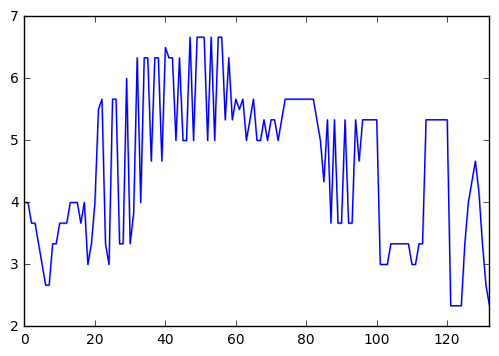

In [636]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [637]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
#    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    return np.arctan2(LA.norm(np.cross(v1_u, v2_u)), np.dot(v1_u, v2_u))
    

In [638]:
def point_theta(center, A):
    thetas = []; 
    Ref_pt = [A.iloc[0]['X'], A.iloc[0]['Y'], A.iloc[0]['Z']] 
    Ref_V = np.subtract(Ref_pt, center)
    for index, row in A.iterrows():
        pt = [row['X'], row['Y'], row['Z']]
        pt_V = np.subtract(pt, center)
        #theta = angle_between(Ref_pt, pt)
        theta = angle_between(Ref_V, pt_V)
        theta = theta * 180 / np.pi
        thetas.append(theta)
    return thetas


In [639]:
thetas = point_theta(center_data, df_data)

In [640]:
thetas_df = pd.Series(thetas, name='theta');

In [641]:
thetas_df.describe()

count    2284.000000
mean       91.487775
std        49.614480
min         0.000000
25%        50.962575
50%        91.408911
75%       133.880926
max       175.547393
Name: theta, dtype: float64

In [642]:
df_data_with_theta = pd.concat([df_data, thetas_df], axis=1)

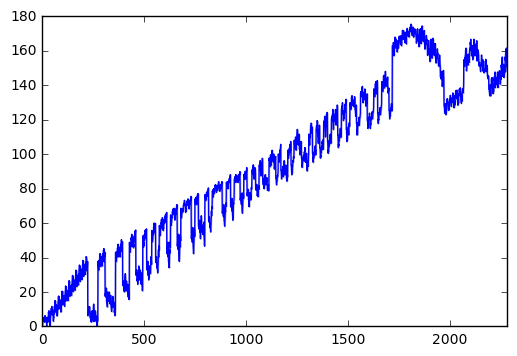

In [643]:
sns.tsplot(df_data_with_theta['theta'])

In [644]:
df_data_with_thetas_sorted = df_data_with_theta.sort_values(by='theta')

In [645]:
df_data_with_thetas_sorted.head(10)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,4954,-8.51376,8.55110,-22.4372,0,4.0,0.000000
1,0,4954,-8.51376,8.55110,-22.4372,3,4.0,0.000000
22,1,4954,-8.51376,8.55110,-22.4372,1,4.0,0.000000
38,2,4954,-8.51376,8.55110,-22.4372,1,4.0,0.000000
269,15,4954,-8.51376,8.55110,-22.4372,1,4.0,0.000000
241,13,5284,-9.13681,8.87638,-22.1038,1,4.0,2.511033
28,1,5284,-9.13681,8.87638,-22.1038,1,4.0,2.511033
270,15,5284,-9.13681,8.87638,-22.1038,2,4.0,2.511033
11,0,5284,-9.13681,8.87638,-22.1038,1,4.0,2.511033
268,15,4953,-7.85926,8.25531,-22.7636,1,4.0,2.536233


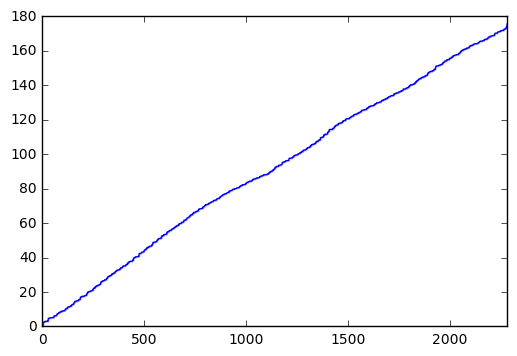

In [646]:
sns.tsplot(df_data_with_thetas_sorted['theta'])

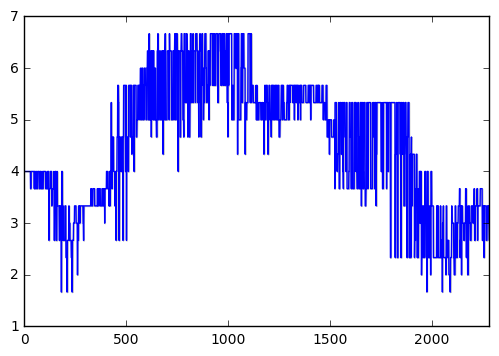

In [647]:
sns.tsplot(df_data_with_thetas_sorted['MeshScalar'])

In [648]:
df_data_with_thetas_sorted.head(15)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,4954,-8.51376,8.55110,-22.4372,0,4.0,0.000000
1,0,4954,-8.51376,8.55110,-22.4372,3,4.0,0.000000
22,1,4954,-8.51376,8.55110,-22.4372,1,4.0,0.000000
38,2,4954,-8.51376,8.55110,-22.4372,1,4.0,0.000000
269,15,4954,-8.51376,8.55110,-22.4372,1,4.0,0.000000
241,13,5284,-9.13681,8.87638,-22.1038,1,4.0,2.511033
28,1,5284,-9.13681,8.87638,-22.1038,1,4.0,2.511033
270,15,5284,-9.13681,8.87638,-22.1038,2,4.0,2.511033
11,0,5284,-9.13681,8.87638,-22.1038,1,4.0,2.511033
268,15,4953,-7.85926,8.25531,-22.7636,1,4.0,2.536233


In [649]:
df_data_with_thetas_sorted['MeshScalar'].std()

1.2680754344878982

In [650]:
df_data_with_thetas_sorted.head()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,4954,-8.51376,8.5511,-22.4372,0,4.0,0.0
1,0,4954,-8.51376,8.5511,-22.4372,3,4.0,0.0
22,1,4954,-8.51376,8.5511,-22.4372,1,4.0,0.0
38,2,4954,-8.51376,8.5511,-22.4372,1,4.0,0.0
269,15,4954,-8.51376,8.5511,-22.4372,1,4.0,0.0


In [651]:
df_data_with_thetas_sorted_nodupes = df_data_with_thetas_sorted.drop_duplicates(subset='VertexID', keep='last');

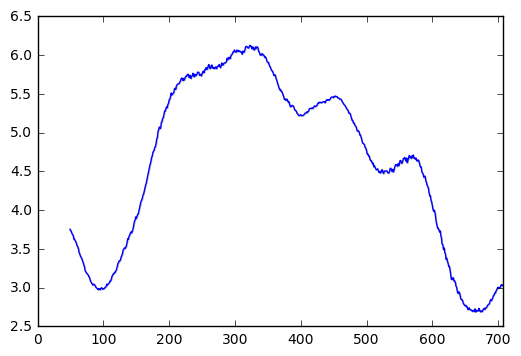

In [652]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted_nodupes['MeshScalar'],50))

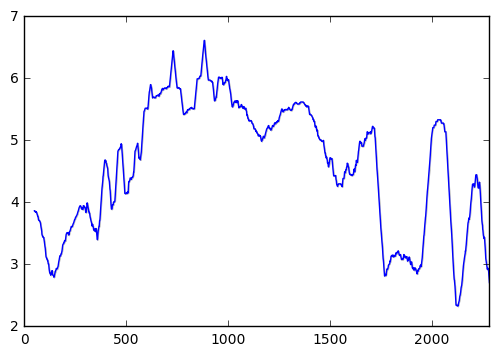

In [653]:
sns.tsplot(pd.rolling_mean(df_data_with_theta['MeshScalar'], 50))

In [654]:
df_data_with_thetas_sorted_nodupes.describe()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
count,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000
mean,66.943503,12239.370056,-2.444581,6.020105,-5.860367,1.183616,4.530602,91.917629
std,38.550904,5282.930139,8.685703,10.112607,11.325365,0.521300,1.291362,49.353254
min,0.000000,4628.000000,-17.246900,-12.568600,-23.748300,0.000000,1.666670,0.000000
25%,34.000000,7007.750000,-10.338675,-2.786610,-17.038025,1.000000,3.333330,52.502833
50%,67.000000,12098.500000,-1.285250,8.078675,-5.166885,1.000000,4.666670,91.832539
75%,100.000000,17931.750000,5.728248,14.981650,6.035335,1.000000,5.333330,134.060556
max,132.000000,19719.000000,11.205500,20.741500,9.215560,3.000000,6.666670,175.547393


In [655]:
''' 
This function is not complete yet, it tries to compute the distance between each point in the list to its
point on the line (vertex depth = v for all points within the same neighbourhood) 
'''
def scar_width(df, threshold):
    width = []; 
    is_scar = []; 
    #Ref_pt = [A.iloc[0]['X'], A.iloc[0]['Y'], A.iloc[0]['Z']] 
    
    for index, row in df.iterrows():
        if row['VertexDepth'] == 0:
            pt_on_line = (row['X'], row['Y'], row['Z'])
            
        pt = (row['X'], row['Y'], row['Z'])
        #distance = math.hypot(pt[0]-pt_on_line[0], pt[1]-pt_on_line[1], pt[1]-pt_on_line[1])
        distance = math.sqrt((pt[0]-pt_on_line[0])**2 + (pt[1]-pt_on_line[1])**2 + (pt[2]-pt_on_line[2])**2)
        
        
        if row['MeshScalar'] > threshold: 
            is_scar.append(1) 
            width.append(distance)
        else:
            is_scar.append(0)
            width.append(0)
    
    width_df = pd.Series(width, name='scar_width');
    is_scar_df = pd.Series(is_scar, name='scar_bin');
    
    df = pd.concat([df, width_df], axis=1)
    df = pd.concat([df, is_scar_df], axis=1)

    return df

In [656]:
df_data_with_thetas_sorted = scar_width(df_data_with_thetas_sorted, 2.2)

In [657]:
df_data_with_thetas_sorted['MeshScalar'].mean()

4.568738892294128

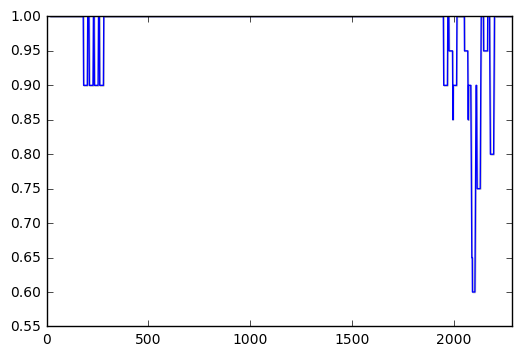

In [658]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted['scar_bin'],20))

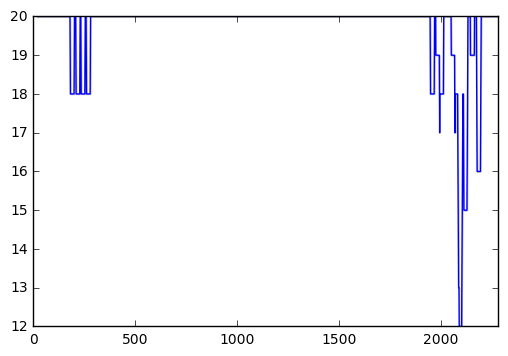

In [659]:
sns.tsplot(pd.rolling_sum(df_data_with_thetas_sorted['scar_bin'],20))

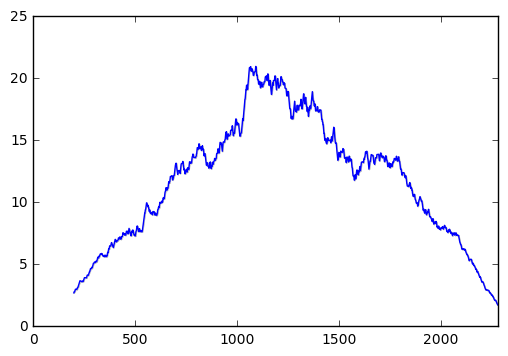

In [660]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted['scar_width'],200)) # Uses mean windowing=100, so 0 widths are smoothed

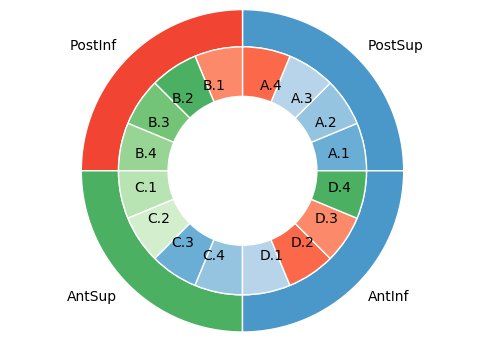

In [661]:
# Libraries
# See https://python-graph-gallery.com/163-donut-plot-with-subgroups/
import matplotlib.pyplot as plt
 
# Make data: I have 3 groups and 7 subgroups
group_names=['PostSup', 'PostInf', 'AntSup', 'AntInf']
group_size=[1,1,1,1]
subgroup_names=['A.1', 'A.2', 'A.3', 'A.4','B.1', 'B.2', 'B.3', 'B.4', 'C.1', 'C.2', 'C.3', 'C.4', 'D.1', 'D.2', 'D.3', 'D.4']
subgroup_size=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
 
# Create colors
a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6), c(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), c(0.6), c(0.5), c(0.4), c(0.3), c(0.2)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.show()


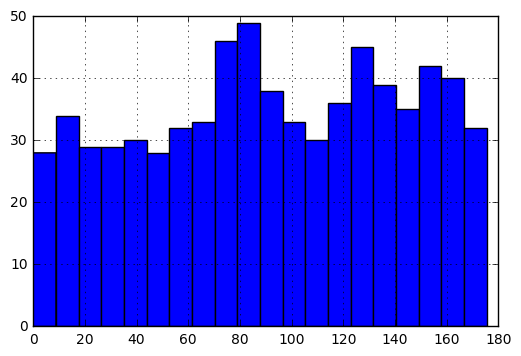

In [662]:
df_data_with_thetas_sorted_nodupes['theta'].hist(bins=20)

In [663]:
test_array = df_data_with_theta.as_matrix(columns=df_data_with_theta.columns[7:8])

In [664]:
test_array.shape


(2284, 1)

In [665]:
2639/12

219

In [666]:
scar_grps

array([ 4.     ,  4.     ,  4.     , ...,  2.33333,  2.33333,  2.33333])